# Tree Based Models for Classification and Regression

In this file, I am using tree based models and ensembles to predict the following:

* Price direction (classifying whether the closing price will increase or decrease)
* Slope or price (classifying whether the slope will be more or less steep)
* Percentage of change in price

In [4]:
#imports
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import pandas as pd
import datetime
#from scipy.stats import ttest_ind_from_stats
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor #For Classification
from sklearn.metrics import confusion_matrix
import scipy.stats as sp
#from sklearn.model_selection import cross_val_score
from scipy.stats.stats import pearsonr
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from sklearn import tree
from IPython.display import Image  
import talib
#from scipy.stats import ttest_ind_from_stats
import MySQLdb


#### Getting 41,652 bars of USD/JPY 1 hour data from MySql database, period from 2010-10-01 00:00:00 to 2017-06-09 19:00:00 

In [26]:
# getting data

db_pass="coderunner"
db_user="root"
db_name="quant"
db_table="USDJPY_H1"

try:
    #print(db)
    db = MySQLdb.connect("localhost","%s"%db_user,"%s"%db_pass,"%s"%db_name )
    #print(db)
    sql = "SELECT * FROM %s"%db_table
    currencyy = pd.read_sql(sql,db )
    '''sql = "SELECT * FROM %s"%db_table_2
    curr2= pd.read_sql(sql,db )
    
    curr2=curr2.drop(["timestamp"], axis=1)
    
    currencyy=currencyy.join(curr2, rsuffix="__")'''
    currency=currencyy
    db.close()
except:
    print("Error: unable to fecth data")

In [27]:
currency.head()

,timestamp,open,high,low,close,volume
0,2010-10-01 00:00:00,83.502,83.550,83.436,83.470,234
1,2010-10-01 01:00:00,83.472,83.524,83.435,83.457,236
2,2010-10-01 02:00:00,83.454,83.546,83.448,83.498,126
3,2010-10-01 03:00:00,83.492,83.512,83.370,83.377,134
4,2010-10-01 04:00:00,83.378,83.494,83.377,83.426,198


##### Building training and test sets of sizes X & X respectively
Features that will be used are open, close, high, low, volume, slope of closed price and percentage of changes for all mentioned features

In [28]:
# building training and testing data 
testSize=1200

# adding slope
currencyy["tiSlope"]=talib.LINEARREG_SLOPE(close, timeperiod=2)

#calculating percentages of change
for i in currencyy.columns:
    
    if i not in ["timestamp"]:
        if currencyy[i].mean() != 0.0:
            n= "%s_PC"%i
            currencyy[n]=currencyy[i].pct_change()

#building target variables and some cleaning             
currencyy=currencyy[1::]
currencyy=currencyy.reset_index(drop=True)
Y = currencyy.tiSlope.diff()
Y = Y>0
YY=currencyy.close.diff()
YY=YY>0
YYYY=currencyy.close_PC

Xtoday = currencyy[-1::]

currencyy=currencyy.shift(1)
currencyy=currencyy[1::]
Y= Y[1::]
YY=YY[1::]
YYYY=YYYY[1::]
currencyy=currencyy.reset_index(drop=True)
Y=Y.reset_index(drop=True)
YY=YY.reset_index(drop=True)
YYYY=YYYY.reset_index(drop=True)

Xtrain = currencyy[0:len(currencyy)-testSize]
Ytrain = Y[0:len(currencyy)-testSize]
YYtrain= YY[0:len(currencyy)-testSize]
YYYYtrain= YYYY[0:len(currencyy)-testSize]

Xtest = currencyy[len(currencyy)-testSize::]
Ytest = Y[len(currencyy)-testSize::]
YYtest= YY[len(currencyy)-testSize::]
YYYYtest= YYYY[len(currencyy)-testSize::]

Xtest = Xtest.reset_index(drop=True)
Ytest = Ytest.reset_index(drop=True)
YYtest = YYtest.reset_index(drop=True)
YYYYtest = YYYYtest.reset_index(drop=True)


#imputing NA's and inf's with means for training data set, NA's and inf's are resulted from calculating percentages of change when we are dividing by zero or dividing zero
for i in Xtrain.columns:
    if i not in ["timestamp"]:
        if np.isinf(Xtrain[i]).any():
            
            Xtrain[i]=Xtrain[i].replace([np.inf], Xtrain[i][(Xtrain[i]!=np.inf) & (Xtrain[i]!=-np.inf)].mean())
            Xtrain[i]=Xtrain[i].replace([-np.inf], Xtrain[i][(Xtrain[i]!=np.inf)   & (Xtrain[i]!=-np.inf)].mean()*(-1))
        
        if np.isnan(Xtrain[i]).any():
            Xtrain[i] = Xtrain[i].fillna( Xtrain[i][(Xtrain[i]!=np.inf) & (Xtrain[i]!=-np.inf)].mean())
            
#NA's and inf's of test set will be imputed by the means of training data;       
    
for i in Xtest.columns:
    if i not in ["timestamp"]:
        if np.isinf(Xtest[i]).any():
            Xtest[i]=Xtest[i].replace([np.inf], Xtrain[i].mean())
            Xtest[i]=Xtest[i].replace([-np.inf], Xtrain[i].mean()*(-1))
        
        
        if np.isnan(Xtest[i]).any():
            Xtest[i]=Xtest[i].fillna(Xtrain[i].mean())
            
        if np.isinf(Xtoday[i]).any():
            Xtoday[i]=Xtoday[i].replace([np.inf], Xtrain[i].mean())
            Xtoday[i]=Xtoday[i].replace([-np.inf], Xtrain[i].mean()*(-1))
            
        if np.isnan(Xtoday[i]).any():
            Xtoday[i]=Xtoday[i].fillna(Xtrain[i].mean())

nn=Xtrain.columns.drop(["timestamp"])

Now we have a training data (Xtrain) of 40450 observations from period 2010-10-01 01:00:00 to 2017-03-31 18:00:00 and test data (Xtest) of 1200 observations from period 2017-03-31 19:00:00 to 2017-06-09 18:00:00

our target variables are:
- Price direction classes (True/False) ===> YYtrain
- Slope direction classes (True/False) ===> Ytrain
- Price percentage of change values ====> YYYYtrain

The below table shows how our sets look like

In [42]:
Xtrain.head()

,timestamp,open,high,low,close,volume,tiSlope,open_PC,high_PC,low_PC,close_PC,volume_PC,tiSlope_PC
0,2010-10-01 01:00:00,83.472,83.524,83.435,83.457,236,-0.013,-0.000359,-0.000311,-0.000012,-0.000156,0.008547,-0.976380
1,2010-10-01 02:00:00,83.454,83.546,83.448,83.498,126,0.041,-0.000216,0.000263,0.000156,0.000491,-0.466102,-4.153846
2,2010-10-01 03:00:00,83.492,83.512,83.370,83.377,134,-0.121,0.000455,-0.000407,-0.000935,-0.001449,0.063492,-3.951220
3,2010-10-01 04:00:00,83.378,83.494,83.377,83.426,198,0.049,-0.001365,-0.000216,0.000084,0.000588,0.477612,-1.404959
4,2010-10-01 05:00:00,83.427,83.485,83.416,83.480,184,0.054,0.000588,-0.000108,0.000468,0.000647,-0.070707,0.102041


In [88]:
# function to show results such as accuracy scores and confusion matrices 
def results__(GB, Xtest, nn, YYtest, YYtrain ):
    probss = GB.predict_proba(Xtest[nn])
    probss=pd.DataFrame(probss)
    predss = GB.predict(Xtest[nn])

    pddd = pd.concat([Xtest.timestamp, pd.Series(predss, name="MA_next_bar_prediction"), pd.Series(probss[0], name="MA_p0"), pd.Series(probss[1], name = "MA_p1")], axis=1)

    print("\nTraining set score: %f"%(GB.score(Xtrain[nn], YYtrain)))
    print("\nTest set score: %f"%(GB.score(Xtest[nn], YYtest)))
    print("\nTest set confusion matrix \n")
    print(confusion_matrix(y_pred=GB.predict(Xtest[nn]), y_true=YYtest))
    print("\n")

    #Probability Range

    Test = Xtest[nn]
    YYY = YYtest
    clf = GB
    #Test = Xtrain[nn]
    #YYY=Ytrain


    probs = clf.predict_proba(Test)
    probs = pd.DataFrame(probs)
    probs = pd.concat([YYY,probs,pd.Series(probs[1]>0.5), (YYY ==1).values == pd.Series(probs[1]>0.5) ], axis=1)
    probs.columns=['Ytrue', 'p0','p1','pred','e' ]
    confmat = pd.concat([pd.DataFrame(probs[(probs.e)& (probs.pred)].p1.describe()),pd.DataFrame(probs[(probs.e==1)& (probs.pred==0)].p0.describe()),pd.DataFrame(probs[(probs.e==0)& (probs.pred)].p1.describe()),pd.DataFrame(probs[(probs.e==0)& (probs.pred==0)].p0.describe())], axis=1)
    confmat.columns=["True Positives", "True Negatives", "False Positives", "False Negatives"]


    ppp=pd.DataFrame(clf.predict_proba(Test))
    p00=pd.Series(ppp[0][ppp[0]>0.5])
    p11=pd.Series(ppp[1][ppp[1]>0.5])
    ttt=pd.concat([p11,p00])



    pr= [(0.5, ttt.quantile(0.33333333) ),(ttt.quantile(0.33333333), ttt.quantile(0.66666667)),(ttt.quantile(0.66666667),1.1)]

    truepred=[]
    falsepred=[]
    for thhr,thhr2 in pr:
        truepred.append(probs[ (probs.e) & ( ( (probs.pred) & ((probs.p1 >=thhr) &(probs.p1 <thhr2) )) |  ( (probs.pred ==0) & (probs.p0>=thhr) &(probs.p0 <thhr2) )  ) ].count()[1])
        falsepred.append(probs[ (probs.e==0) & ( ( (probs.pred) & ((probs.p1 >=thhr) &(probs.p1 <thhr2) )) |  ( (probs.pred ==0) & (probs.p0>=thhr) &(probs.p0 <thhr2) )  ) ].count()[1])

    probacc=pd.DataFrame([i for i in zip(truepred,falsepred)])
    probacc=probacc.astype(float)
    probacc= pd.concat([probacc, pd.DataFrame(probacc[[0]].values/(probacc[[0]].values+probacc[[1]].values))],axis=1)
    probacc.columns=["True Predictions","False Predictions","True Prediction Rate"]
    probacc.index=["%f - %f "%(pr[0][0], pr[0][1]),"%f - %f "%(pr[1][0], pr[1][1]),"%f - %f "%(pr[2][0], pr[2][1])]
    probacc.index.name="Prediction Probability Range"
    print("\nTest set prediction probability range:\n")
    print(probacc)

    
def plot_acc(GB, Xtest, YYtest, nn):
    sc=[]
    for i in range(0, len(Xtest), 100):
        sc.append(GB.score(Xtest[nn][i:i+100], YYtest[i:i+100]))
    plt.plot(sc,"o-")
    plt.title("Accuracy score of each 100 observation in test set")

    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off') # labels along the bottom edge are off


### Training and testing our first classifier which classifies price direction


Training set score: 0.535377

Test set score: 0.565000

Test set confusion matrix 

[[262 330]
 [192 416]]



Test set prediction probability range:

                              True Predictions  False Predictions  \
Prediction Probability Range                                        
0.500000 - 0.508888                        215                184   
0.508888 - 0.522852                        206                170   
0.522852 - 1.100000                        257                168   

                              True Prediction Rate  
Prediction Probability Range                        
0.500000 - 0.508888                       0.538847  
0.508888 - 0.522852                       0.547872  
0.522852 - 1.100000                       0.604706  


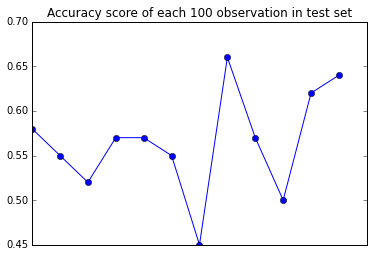

In [89]:
GB=GradientBoostingClassifier(min_samples_leaf=500, n_estimators=20).fit(Xtrain[nn], YYtrain)
results__(GB, Xtest, nn, YYtest, YYtrain )
plot_acc(GB, Xtest, YYtest, nn)

### Second classifier which classifies slope more or less steep


Training set score: 0.753350

Test set score: 0.765000

Test set confusion matrix 

[[459 154]
 [128 459]]



Test set prediction probability range:

                              True Predictions  False Predictions  \
Prediction Probability Range                                        
0.500000 - 0.655621                        213                164   
0.655621 - 0.784399                        334                 89   
0.784399 - 1.100000                        371                 29   

                              True Prediction Rate  
Prediction Probability Range                        
0.500000 - 0.655621                       0.564987  
0.655621 - 0.784399                       0.789598  
0.784399 - 1.100000                       0.927500  


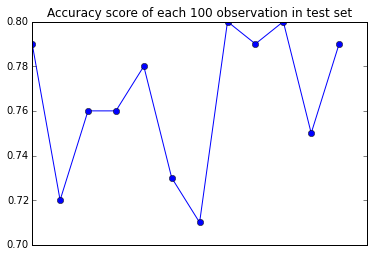

In [90]:
GB2=GradientBoostingClassifier(min_samples_leaf=500, n_estimators=20).fit(Xtrain[nn], Ytrain)
results__(GB2, Xtest, nn, Ytest, Ytrain )
plot_acc(GB2, Xtest, Ytest, nn)

### Third model, a regressor which predict percentage of change in close prices

R^2: -0.024545


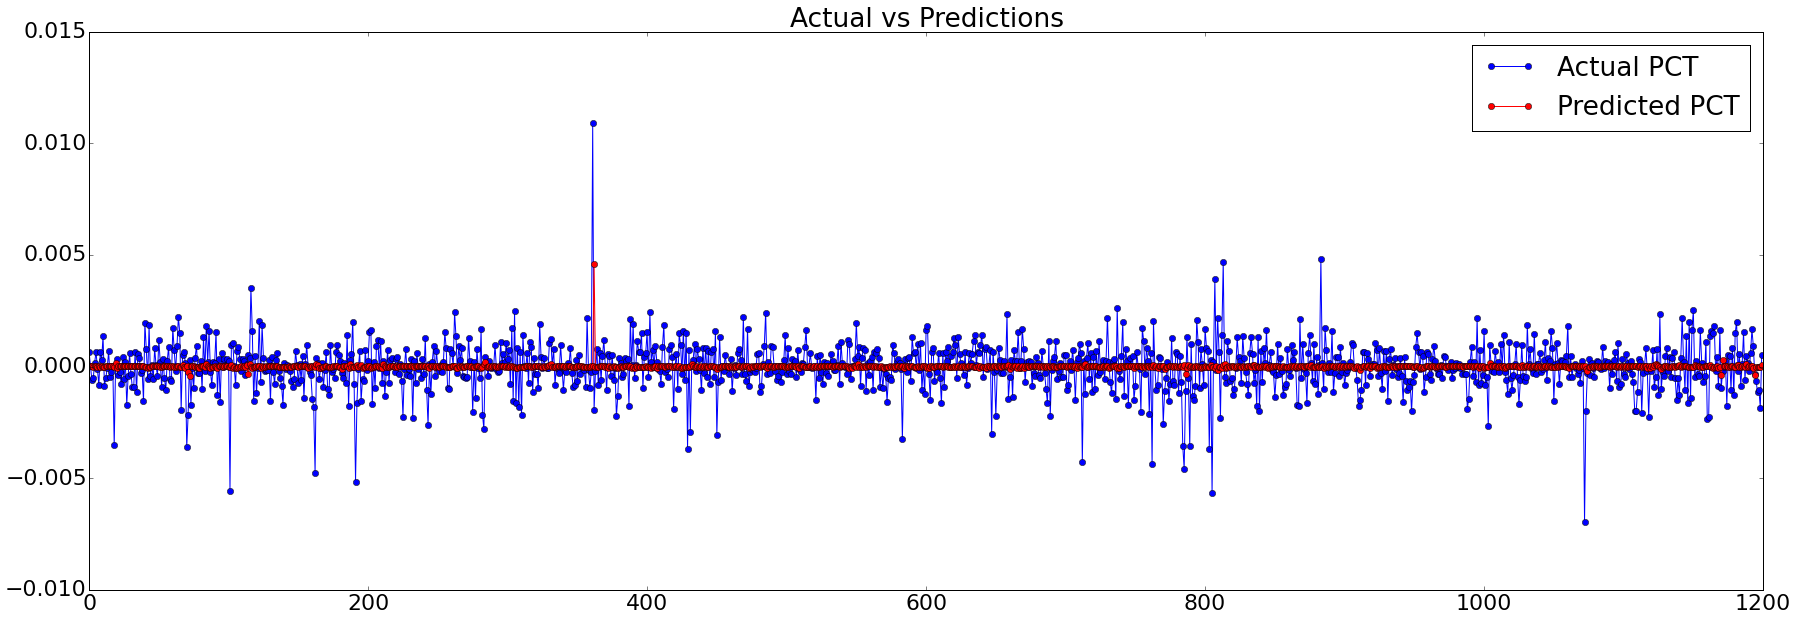

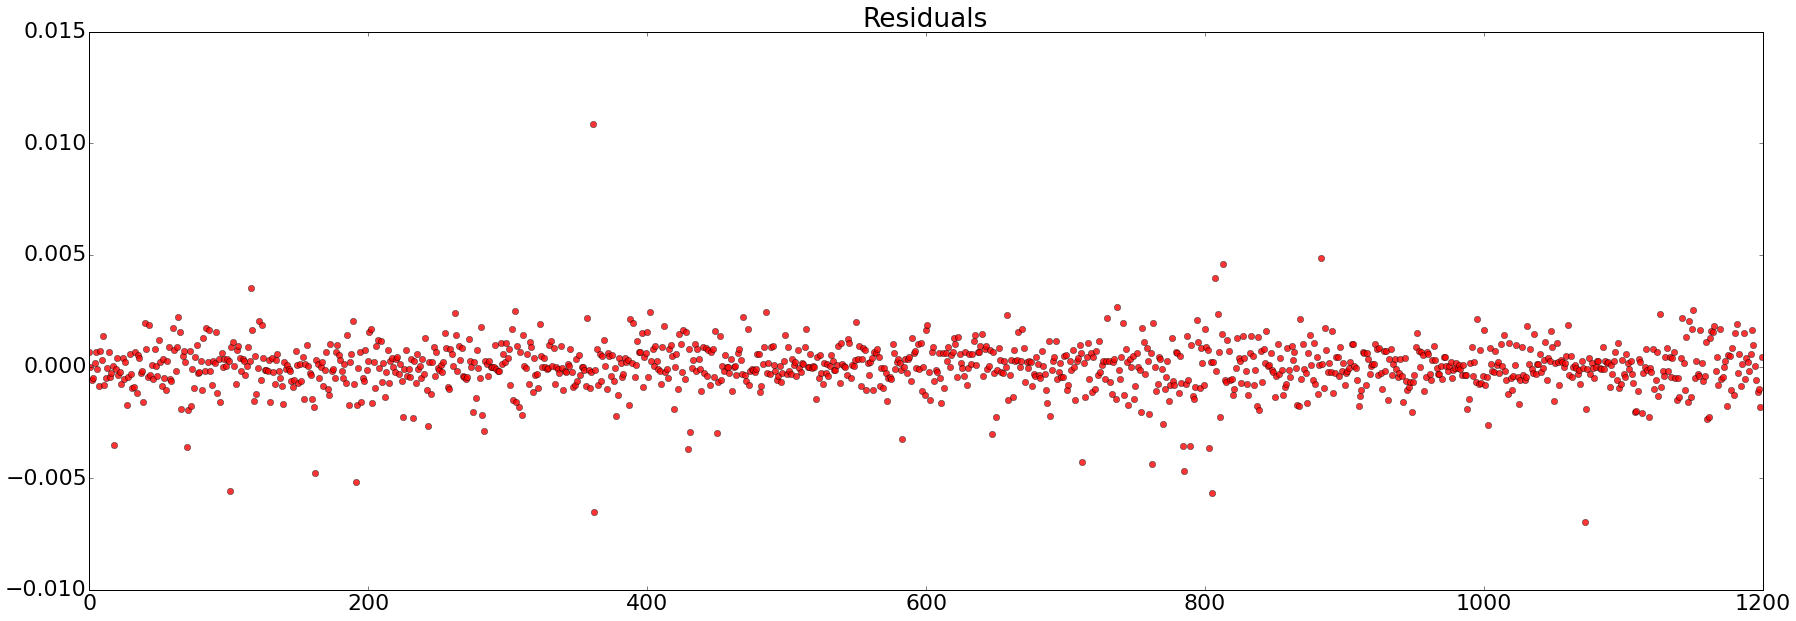

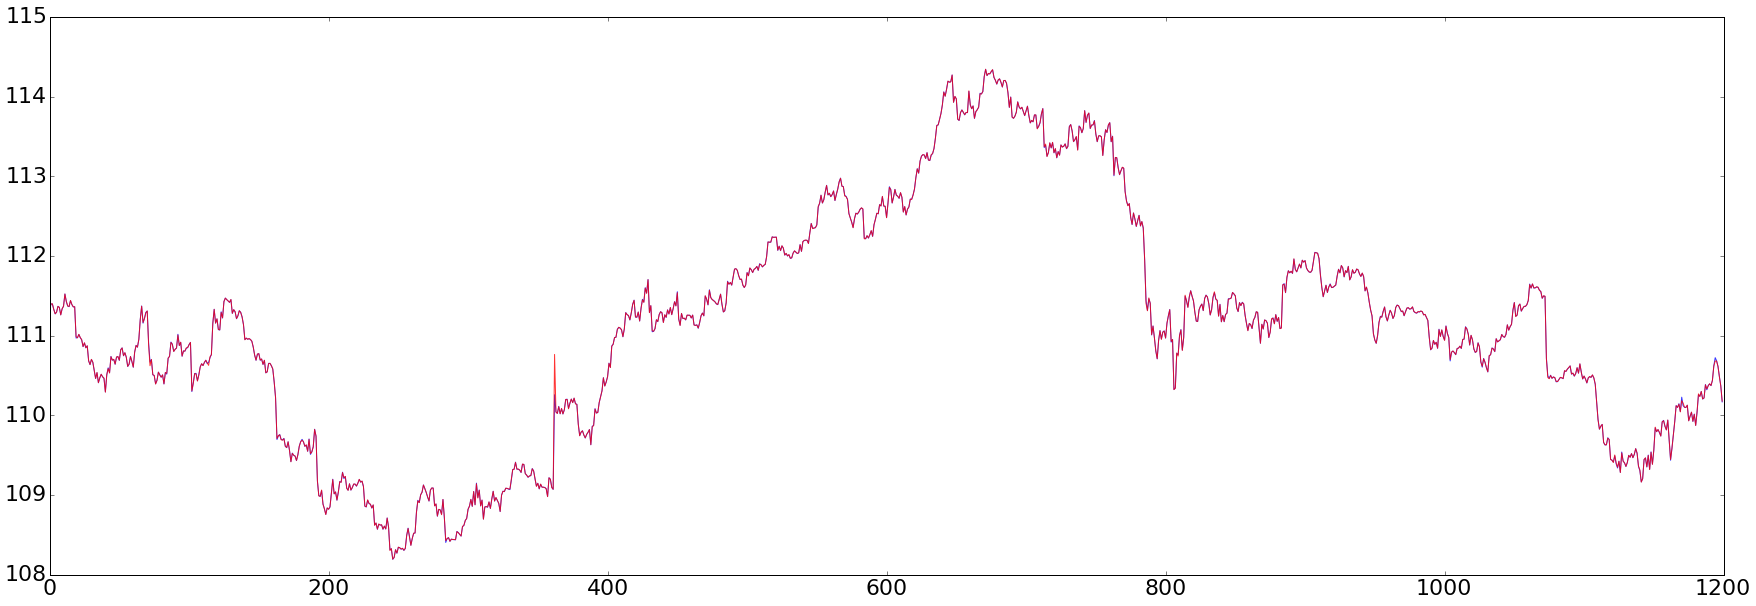

In [271]:
GB3=GradientBoostingRegressor().fit(Xtrain[nn], YYYYtrain)
sc=GB3.score(Xtest[nn], YYYYtest)
print("R^2: %f"%sc)
r=pd.Series(GB3.predict(Xtest[nn]))
#print(((r>0)==(YYYYtest>0)).mean())
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=[30,10])
plt.plot(YYYYtest,"o-", label="Actual PCT")
plt.plot(pd.Series(GB3.predict(Xtest[nn])), "o-",c="red", label="Predicted PCT")
plt.legend()
plt.title("Actual vs Predictions")


r=pd.Series(GB3.predict(Xtest[nn]))
plt.figure(figsize=[30,10])
plt.plot(YYYYtest-r,"o", alpha=0.8, c="red")
plt.title("Residuals")

pr= pd.Series(GB3.predict(Xtest[nn]))
plt.figure(figsize=[30,10])

preds=(Xtest.close*pr)+Xtest.close
plt.plot(Xtest.close, c="blue", alpha=0.8)
plt.plot(preds,c="red", alpha=0.8)

========================================================================================== <br>
As you can see from the first plot, variance of predicted PCT is much less than the variance of the actual PCT. Now lets use a model that has wider variance in predictions
<br>
========================================================================================== <br>

R^2: -0.084280


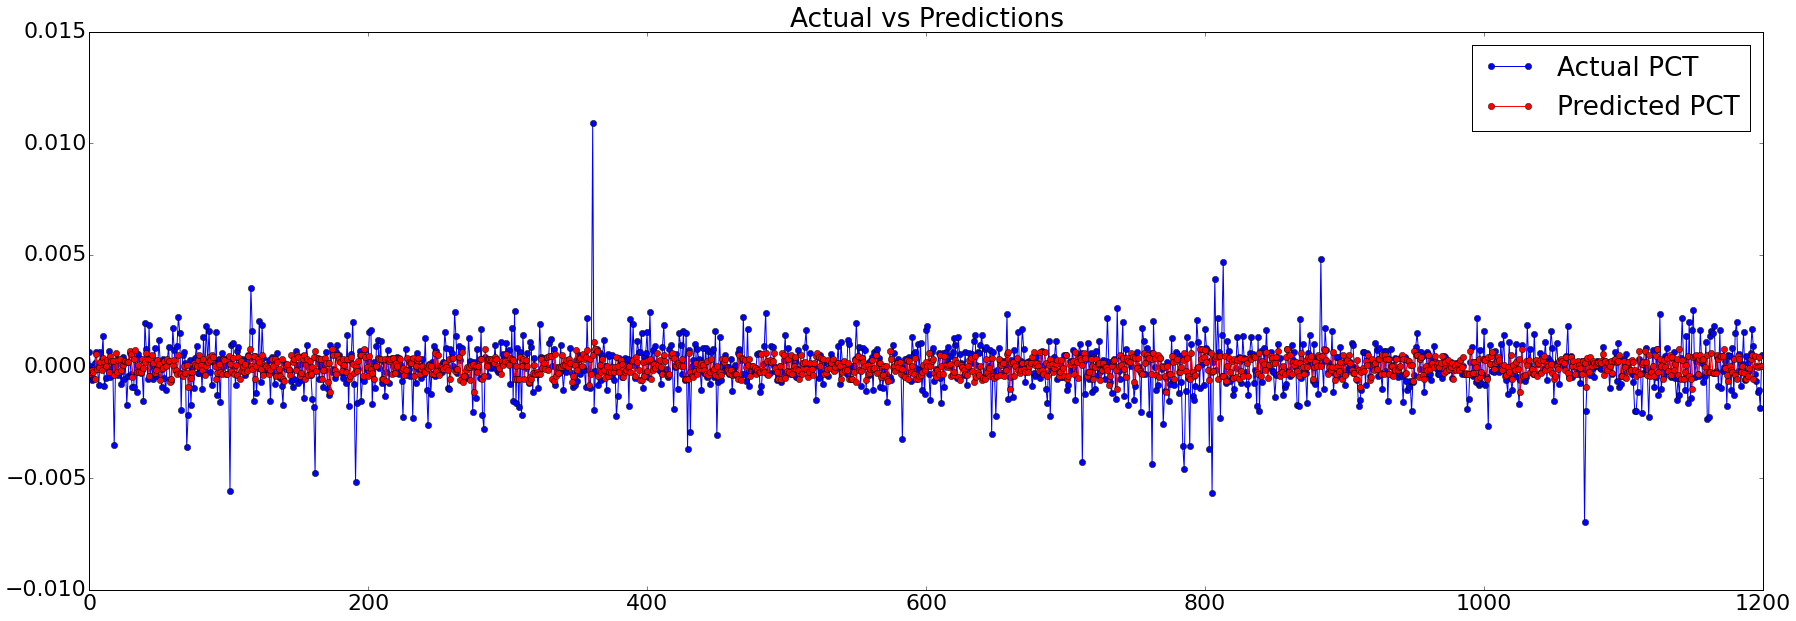

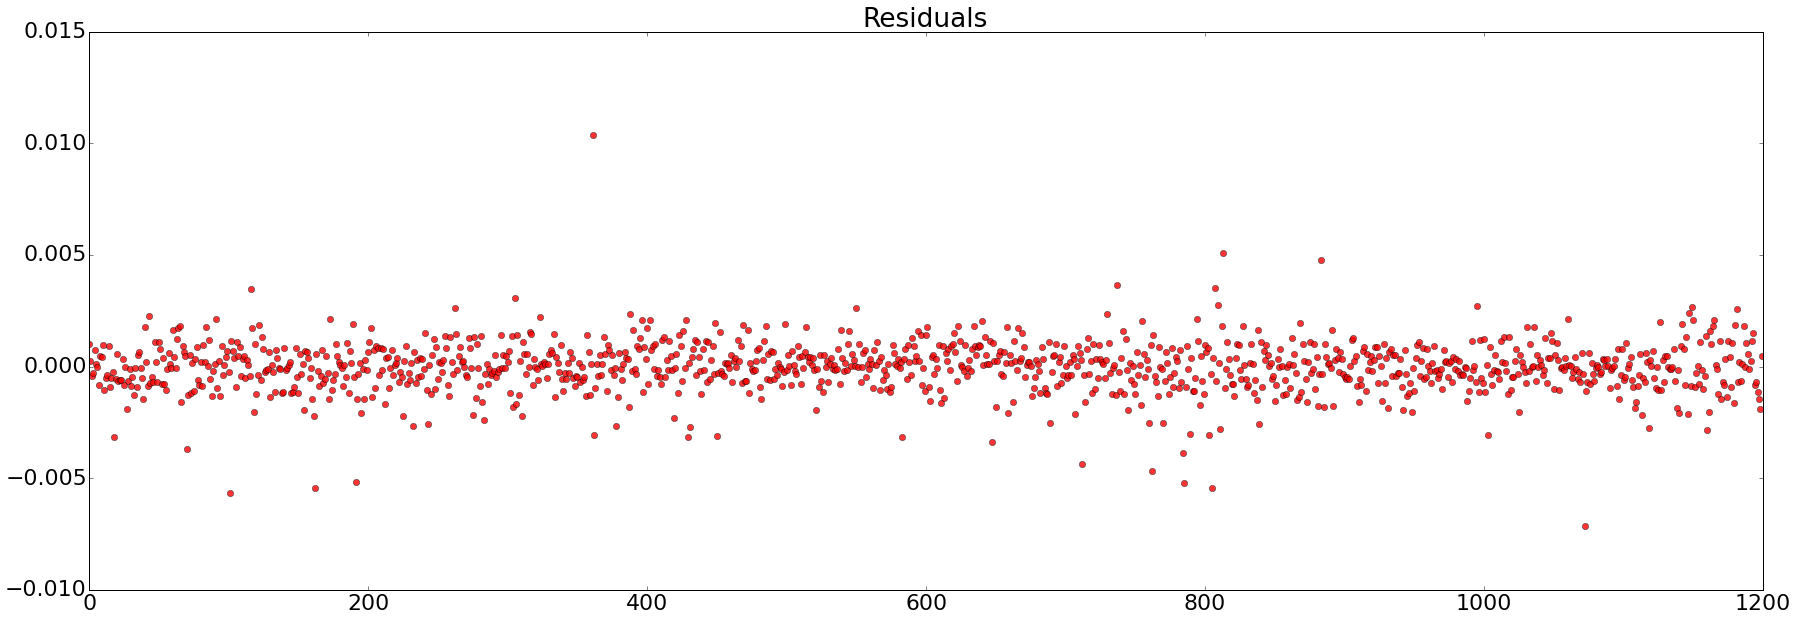

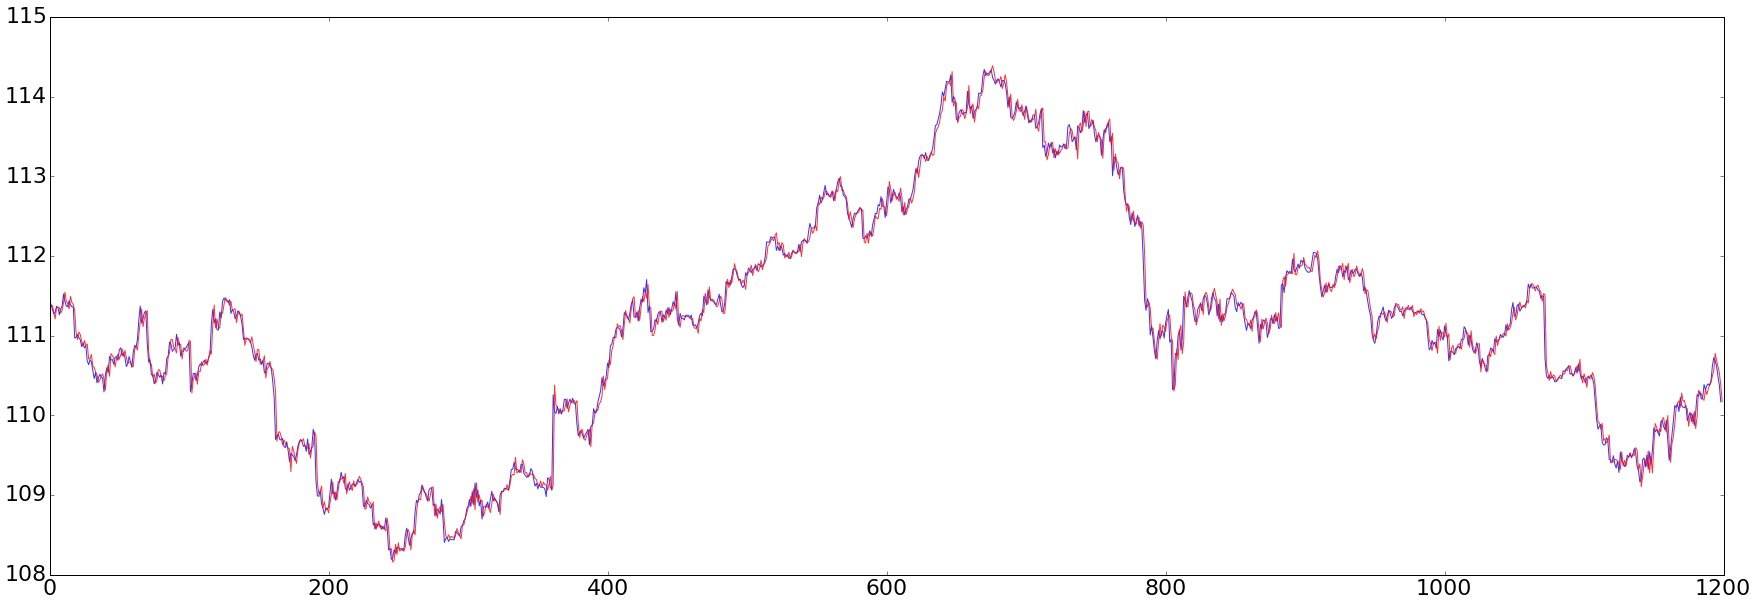

In [295]:
GB4=DecisionTreeRegressor(min_samples_leaf=50).fit(Xtrain[nn], YYYYtrain)
sc2=GB4.score(Xtest[nn], YYYYtest)
print("R^2: %f"%sc2)
r=pd.Series(GB4.predict(Xtest[nn]))
#print(((r>0)==(YYYYtest>0)).mean())
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=[30,10])
plt.plot(YYYYtest,"o-", label="Actual PCT")
plt.plot(pd.Series(GB4.predict(Xtest[nn])), "o-",c="red", label="Predicted PCT")
plt.legend()
plt.title("Actual vs Predictions")


r=pd.Series(GB4.predict(Xtest[nn]))
plt.figure(figsize=[30,10])
plt.plot(YYYYtest-r,"o", alpha=0.8, c="red")
plt.title("Residuals")

pr= pd.Series(GB4.predict(Xtest[nn]))
plt.figure(figsize=[30,10])
preds=(Xtest.close*pr)+Xtest.close
plt.plot(Xtest.close[1::], c="blue", alpha=0.8)
plt.plot(preds,c="red", alpha=0.8)

========================================================================================== <br>
#### This model actually had wider variance than the previous one, but is it actually what we need?
Lets do few comparisons
<br>

==========================================================================================

           Low_variance_model  Higher_variance_model
R-squared           -0.024545               -0.08428


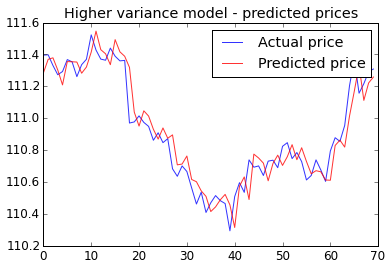

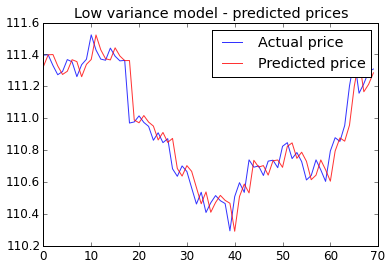

In [307]:
sc=pd.Series(sc)
sc2=pd.Series(sc2)

r2=pd.concat([sc,sc2], axis=1)
r2.columns=["Low_variance_model", "Higher_variance_model"]
r2.index=["R-squared"]
print(r2)

matplotlib.rcParams.update({'font.size': 12})
pr= pd.Series(GB4.predict(Xtest[nn]))
#plt.figure(figsize=[30,10])
preds=(Xtest.close*pr)+Xtest.close
plt.plot(Xtest.close[1:71], c="blue", alpha=0.8, label="Actual price")
plt.plot(preds[0:70],c="red", alpha=0.8,label="Predicted price")
plt.title("Higher variance model - predicted prices")
plt.legend()

pr= pd.Series(GB3.predict(Xtest[nn]))
plt.figure()
preds=(Xtest.close*pr)+Xtest.close
plt.plot(Xtest.close[1:71], c="blue", alpha=0.8,label="Actual price")
plt.plot(preds[0:70],c="red", alpha=0.8,label="Predicted price")
plt.title("Low variance model - predicted prices")
plt.legend()

#### The last two models needs more investigating to be able to assess results.

# Final Notes:

* Models were optimized on a cross validation set before coming up with the final models.
* Data preprocessing and feature extractions techniques such as scaling and PCA were tested but didn't show better results than raw data.
* Feature extractions techniques such as adding technical indicators and statistical variables (mean, standard deviations...etc) were tested, they didn't show better results but a good mix of them and feature selection process might help. I need to work on this.
* Hyper parameters of the models were chosen and cross validated using grid search in a very simple way. better computational power should help us improve our models.
* More than 1 bar lag was tested, no better results were produced.
* Several ML models were tested such as neuralnet, logistic regression, linear regression, baye's, KNN. Trees seems to be the out performing model.
* Other currency pairs were tested. Results are similar.

## Future Work:
* Test other data
* Predict other target variables
* Go through Feature selection and extraction processes again